## Lab: Graph theory

In this lab you will be introduced to graph theory using NetworkX.

### Setup


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy
import pandas
%matplotlib inline


### Example 1: A simple graph

Let's create a graph representing the publication network between four researchers in network neuroscience: Olaf Sporns (OS), Danielle Bassett (DB), Alex Fornito (AF), and  Randy Mcintosh (RM).  

Each node in the graph will represent one of the individuals.  First we need to generate the graph object, and then add the nodes.

In [3]:
researchers={'OS':{'name':'Olaf Sporns'},
            'DB':{'name':'Danielle Bassett'},
            'AF':{'name':'Alex Fornito'},
            'RM':{'name':'Randy Mcintosh'}}

G = nx.Graph()

G.add_nodes_from(researchers.keys())

We can see the nodes using the nodes element in the graph object:

In [4]:
G.nodes

NodeView(('OS', 'DB', 'AF', 'RM'))

Each node in the graph can have attributes associated with it, which we can add to the nodes as we would add a dictionary element:

In [5]:
for researcher in researchers:
    G.nodes[researcher]['name']=researchers[researcher]['name']
    print(researcher,G.nodes[researcher])

OS {'name': 'Olaf Sporns'}
DB {'name': 'Danielle Bassett'}
AF {'name': 'Alex Fornito'}
RM {'name': 'Randy Mcintosh'}


Let's visualize the graph so far using Networkx's visualization tools

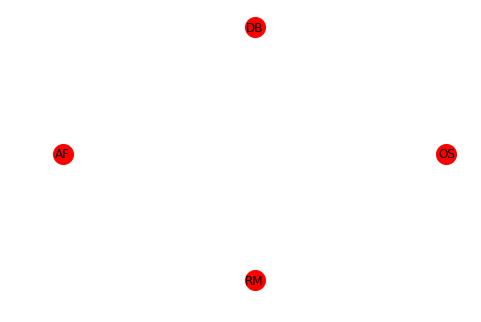

In [6]:
nx.draw_circular(G,with_labels=True,node_size=400)


So far we have a completely disconnected graph - that is, it has no edges (i.e. connections).  Now let's add edges based on the publication history.  First we will generate a matrix containing the number of joint publications between each of the researchers (whcih in this case are made up). 

In [7]:
# first get pubmed search terms from names
for i in researchers:
    i

# create a list to use in making the matrix
# do this so that the order stays fixed
researchers_list=list(researchers.keys()) 

# create a data frame to hold all of the entries
# for each combination of researchers

df=pandas.DataFrame(numpy.zeros((len(researchers),
                                 len(researchers))),
                   index=researchers_list,
                   columns=researchers_list)

# we just fill in the upper triangle of the matrix

df.loc['OS']=[0,3,2,5]
df.loc['DB']=[0,0,0,2]
df.loc['AF']=[0,0,0,1]

print(df)


     OS   DB   AF   RM
OS  0.0  3.0  2.0  5.0
DB  0.0  0.0  0.0  2.0
AF  0.0  0.0  0.0  1.0
RM  0.0  0.0  0.0  0.0


Now let's use the co-publication matrix to generate a binary adjacency matrix, which will represent whether there is a link between each pair of investigators.  This is obtained by thresholding the co-publication matrix; for now we will just threshold at greater than zero, so that any publications are sufficient to create an edge.

In [8]:
threshold=0
adjacency_mtx=(df>threshold).astype('int')
print(adjacency_mtx)

    OS  DB  AF  RM
OS   0   1   1   1
DB   0   0   0   1
AF   0   0   0   1
RM   0   0   0   0


Now let's use the adjacency matrix to determine which pairs have an edge, and then add those to the graph.

In [9]:
matches=numpy.where(adjacency_mtx>0)
for i in range(len(matches[0])):
    G.add_edge(researchers_list[matches[0][i]],
               researchers_list[matches[1][i]])

Now we can see the edges as part of the graph object:

In [10]:
G.edges

EdgeView([('OS', 'DB'), ('OS', 'AF'), ('OS', 'RM'), ('DB', 'RM'), ('AF', 'RM')])

And we can now visualize the graph with the edges included.

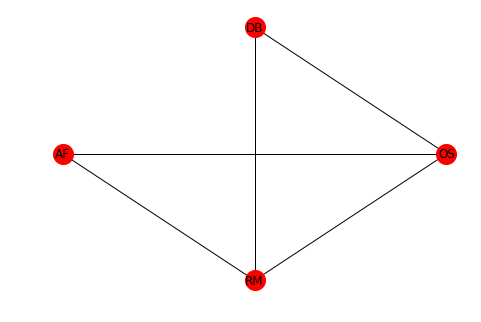

In [11]:
nx.draw_circular(G,with_labels=True,node_size=400)


### Node characteristics

Now that the graph is generated, we can examine the characteristics of some of the nodes.  First, let's look at the number of edges for each node - that is, its *degree*. This is stored in the degree element within the graph object.

In [12]:
G.degree

DegreeView({'OS': 3, 'DB': 2, 'AF': 2, 'RM': 3})

We could also compute the degree by summing the adjacency matrix, though we would first need to make it symmetric:

In [13]:
adjacency_mtx_symm=adjacency_mtx+adjacency_mtx.T
adjacency_mtx_symm['degree']=adjacency_mtx_symm.sum(1)
print(adjacency_mtx_symm)

    OS  DB  AF  RM  degree
OS   0   1   1   1       3
DB   1   0   0   1       2
AF   1   0   0   1       2
RM   1   1   1   0       3


It's also common to present the adjacency matrix as an image, with the color scale (usually black/white) denoting the presence/absence of connections.

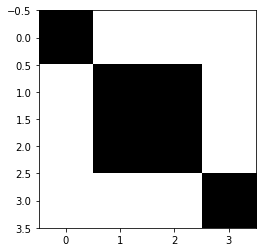

In [25]:
plt.imshow(adjacency_mtx+adjacency_mtx.T,cmap='gray')

### Example 2: A more complex network

The example above was nice to get started, but usually we work with much larger networks.  For a more realistic example, let's look at some Facebook friendship data from the Stanford Large Network Database: https://snap.stanford.edu/data/egonets-Facebook.html

In [14]:
facebook_data=pandas.read_csv('data/facebook_combined.txt',sep=' ',
                             header=None)
# generate a networkx graph
G_facebook=nx.Graph()
for i in facebook_data.index:
    G_facebook.add_edges_from([tuple(facebook_data.loc[i])])



Let's visualize this network, first in a circular arrangement like we did above.

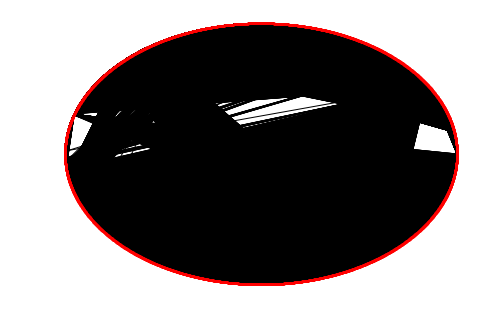

In [15]:
nx.draw_circular(G_facebook,node_size=2)

The circular graph is not very useful because it's hard to see the structure of the network.  Now let's draw it using a spring embedding algorithm, which arranges the nodes ...

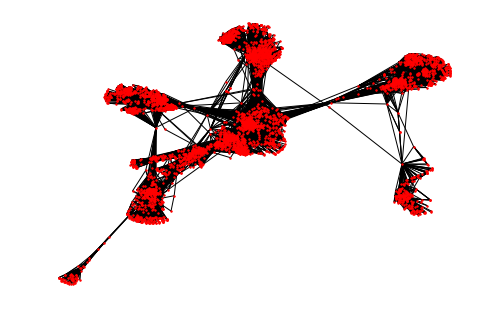

In [16]:
nx.draw_spring(G_facebook,node_size=2)

This does a much better job of showing the structure of the network. In particular, we can see that there are groups of individuals clustered together. We will examine this further in later exercises.


### Degree distributions

The degree distribution of a network can provide a glimpse into its structure, especially for large networks. Let's plot a histogram the degree distribution for this dataset.

mean degree: 43.69101262688784
max degree: 1045


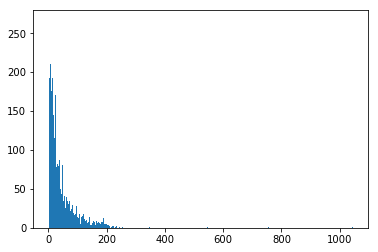

In [17]:
degree_vals = [G_facebook.degree[i] for i in G_facebook.nodes]
degree_dist = plt.hist(degree_vals,500)
print('mean degree:',numpy.mean(degree_vals))
print('max degree:',numpy.max(degree_vals))


This is a very long-tailed distribution - the highest degree is more than 20 times the mean!  This kind of degree distribution is commonly seen in complex networks.  Often these are characterized by a power law relationship between degree and frequency (though this is tricky to establish - see Clauset et al., 2008).  A power law is linear in log coordinates, so we can plot the data as log-log to see this:

/Users/poldrack/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


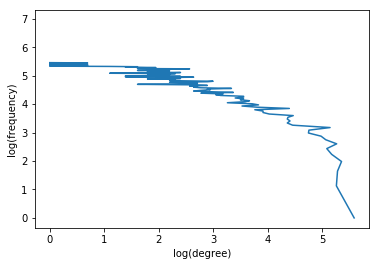

In [18]:
binsize=degree_dist[1][1]-degree_dist[1][0]
plt.plot(numpy.log(degree_dist[0]),numpy.log(degree_dist[1][1:]-binsize))
plt.xlabel('log(degree)')
plt.ylabel('log(frequency)')

This looks fairly linear until it gets to the tail, where it drops off faster than expected. This is indicative of a truncated power law, which is also commonly seen.

What would we expect the degree distribution to look like if the network was randomly connected? Let's write a simulation to generate a network with the same mean degree and number of nodes, but with random connections.

In [19]:
def mk_random_graph(G_init,verbose=False,maxiter=5):
    # need to divide the number of edges by two since 
    edgelist=numpy.random.randint(len(G_init.nodes),
                                  size=(len(G_init.edges),2))
    good_list=False
    iter=0
    while not good_list:
        if iter>maxiter:
            print('hit maxiter')
            return None
        if verbose:
            print(len(edgelist))
        edgelist=edgelist[edgelist[:,0]!=edgelist[:,1]]
        if verbose:
            print('self-edge removal',len(edgelist))
        edgelist=numpy.sort(edgelist,axis=1)
        edgelist=numpy.unique(edgelist,axis=0)
        if verbose:
            print('duplicate removal',len(edgelist))
        if len(edgelist)==len(G_init.edges):
            good_list=True
        else:
            iter+=1
            edgelist=numpy.vstack((edgelist,
                        numpy.random.randint(len(G_init.nodes),
                                size=(len(G_init.edges)-len(edgelist),2)) ))
    G_rand=nx.Graph()
    for i in range(edgelist.shape[0]):
        G_rand.add_edge(edgelist[i,0],edgelist[i,1])
        
    return(G_rand)

Let's generate a random network and look at its degree distribution.

random graph:
mean degree: 43.69101262688784
max degree: 69


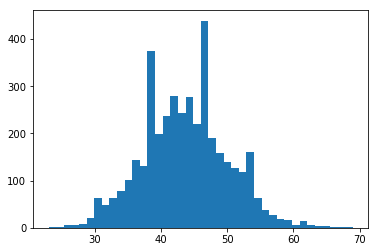

In [20]:
G_rand=mk_random_graph(G_facebook)
degree_vals_rand = [G_rand.degree[i] for i in G_rand.nodes]
degree_dist_rand = plt.hist(degree_vals_rand,40)
print('random graph:')
print('mean degree:',numpy.mean(degree_vals_rand))
print('max degree:',numpy.max(degree_vals_rand))


Let's also visualize the data to see what a randomly connected network looks like.

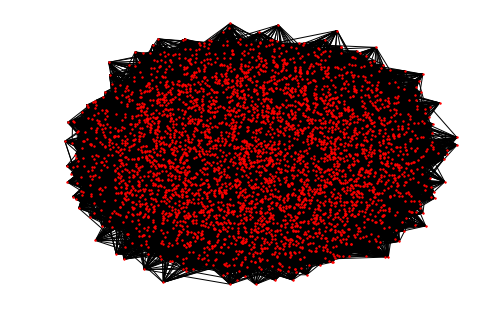

In [21]:
nx.draw_spring(G_rand,node_size=2)